In [15]:
import pandas as pd
import numpy as np

pd.set_option('display.float_format', lambda x: '%.2f' % x)

df = pd.read_excel('Canada Cattle.xlsx')

# Set Year as index and convert to_period to yearly
df['Year'] = pd.to_datetime(df['Year'], format='%Y')
df = df.set_index('Year')
df = df.to_period('Y')

# df.describe()

# Copy the dataframe
df_full = df.copy()

# Split dataframes into Cattle and Calves
df_cattle = df.copy()
df_cattle.drop(['Count of Calves','Average Weight Cattle', 'Average Weight Calves'], axis=1, inplace=True)

df_calve = df.copy()
df_calve.drop(['Count of Cattle','Average Weight Cattle', 'Average Weight Calves'], axis=1, inplace=True)


# df_cattle.head()
# df.plot()

LSTM For Cattle

In [16]:
# Use Dickey-Fuller test to test for stationarity
from statsmodels.tsa.stattools import adfuller

# Test for stationarity
result = adfuller(df_cattle['Count of Cattle'])
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

# Reject Null Hyptothesis

ADF Statistic: -1.606172
p-value: 0.480492
Critical Values:
	1%: -3.499
	5%: -2.892
	10%: -2.583


In [17]:
# Convert a differenced series to a stationary series
def difference(dataset, interval=1):
    diff = list()
    for i in range(interval, len(dataset)):
        value = dataset[i] - dataset[i - interval]
        diff.append(value)
    return pd.Series(diff)

# Invert differenced forecast
def inverse_difference(last_ob, value):
	return value + last_ob

# Create a differenced series
diff = difference(df_cattle['Count of Cattle'])

# Invert the differenced series
inverted = [inverse_difference(df_cattle.values[i], diff[i]) for i in range(len(diff))]

In [18]:
# Check for stationarity on the differenced series
result = adfuller(diff)
print('ADF Statistic: %f' % result[0])
print('p-value: %s' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

# Do not reject Null Hypothesis

ADF Statistic: -7.342934
p-value: 1.0535667062841534e-10
Critical Values:
	1%: -3.499
	5%: -2.892
	10%: -2.583


<AxesSubplot:xlabel='Year'>

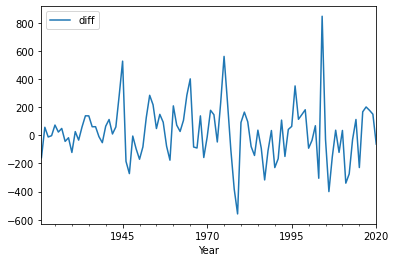

In [19]:
# Convert differenced series to a time-series data, first column is year with index, second column is the difference
df_diff = pd.DataFrame(diff)

# Rename Index to year
df_diff.index.name = 'Year'

# Add 1921 to the index
df_diff.index = df_diff.index + 1921

# Rename Column to difference
df_diff.columns = ['diff']

# Change index to datetime year
df_diff.index = pd.to_datetime(df_diff.index, format='%Y')
# Set index to period year
df_diff = df_diff.to_period('Y')

# Plot the differenced series
df_diff.plot()

# Rename dataframes
# df_old = df
# df = df_diff


In [23]:
# Create an LSTM model
from numpy import array
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import mean_absolute_error
from math import sqrt

# df = df_diff

# Split a univariate sequence into samples
def split_sequence(sequence, n_steps):
    x, y = list(), list()
    for i in range(len(sequence)):
        end_ix = i + n_steps
        if end_ix > len(sequence) - 1:
            break
        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
        x.append(seq_x)
        y.append(seq_y)
    return np.array(x), np.array(y)

# Define input sequence
raw_seq = df_cattle.values
# Choose a number of time steps
n_steps = 3
# Split into samples
x, y = split_sequence(raw_seq, n_steps)
# Reshape from [samples, timesteps] into [samples, timesteps, features]
n_features = 1
x = x.reshape((x.shape[0], x.shape[1], n_features))
# Define LSTM model
model = Sequential()
model.add(LSTM(50, activation='relu', input_shape=(n_steps, n_features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')
# Fit model
model.fit(x, y, epochs=200, verbose=0)
# Make predictions
predictions = model.predict(x)
# demonstrate prediction
x_input = array([[raw_seq[-3], raw_seq[-2], raw_seq[-1]]])
x_input = x_input.reshape((1, n_steps, n_features))
yhat = model.predict(x_input, verbose=0)
print(yhat)

# Calculate RMSE
rmse = sqrt(mean_squared_error(y, predictions))
print('Test RMSE: %.3f' % rmse)

# Calculate MAPE
mape = mean_absolute_percentage_error(y, predictions)
print('Test MAPE: %.3f' % mape)

# Calculate MAE
mae = mean_absolute_error(y, predictions)
print('Test MAE: %.3f' % mae)

4/4 [==============================] - 0s 2ms/step
[[3327.2761]]
Test RMSE: 288.267
Test MAPE: 0.084
Test MAE: 220.813


In [21]:
# # Put predictions in dataframe
# pred_list = list(predictions.flatten())
# pred_list.extend(yhat)

# #undifference the predictions
# undiff_pred = [inverse_difference(df_cattle.values[i], pred_list[i]) for i in range(len(pred_list))]

# # Show last 10 predictions
# print(undiff_pred[-2:])

# len(undiff_pred)

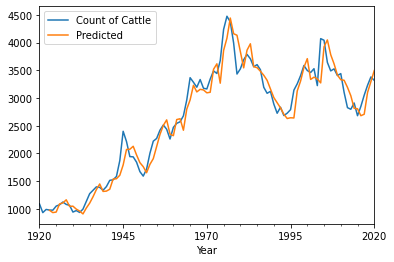

In [22]:
# Compare actual and predicted values in pvt_yr dataframe
from matplotlib import pyplot as plt

pred = [None, None, None]
pred.extend(predictions.flatten())

prt_yr = df_cattle.copy()
prt_yr['Predicted'] = pred

# Plot actual and predicted values
prt_yr.plot()
plt.show()


In [12]:
# make a forecast
def forecast(model, history, n_input):
	# flatten data
	data = array(history)
	data = data.reshape((data.shape[0]*data.shape[1], data.shape[2]))
	# retrieve last observations for input data
	input_x = data[-n_input:, 0]
	# reshape into [1, n_input, 1]
	input_x = input_x.reshape((1, len(input_x), 1))
	# forecast the next week
	yhat = model.predict(input_x, verbose=0)
	# we only want the vector forecast
	yhat = yhat[0]
	return yhat

In [ ]:
# make a forecast for the next 3 years
n_input = 3
forecast = forecast(model, raw_seq, n_input)
print(forecast)


LSTM For Calves

In [7]:
# Use Dickey-Fuller test to test for stationarity
from statsmodels.tsa.stattools import adfuller

# Test for stationarity
result = adfuller(df_calve['Count of Calves'])
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

# Reject Null Hyptothesis

ADF Statistic: -0.172787
p-value: 0.941689
Critical Values:
	1%: -3.502
	5%: -2.893
	10%: -2.583


In [8]:
# Create a differenced series
diff = difference(df_calve['Count of Calves'])

# Invert the differenced series
inverted = [inverse_difference(df_calve.values[i], diff[i]) for i in range(len(diff))]

In [9]:
# Check for stationarity on the differenced series
result = adfuller(diff)
print('ADF Statistic: %f' % result[0])
print('p-value: %s' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

# Do not reject Null Hypothesis

ADF Statistic: -5.400372
p-value: 3.3811211410037007e-06
Critical Values:
	1%: -3.502
	5%: -2.893
	10%: -2.583


<AxesSubplot:xlabel='Year'>

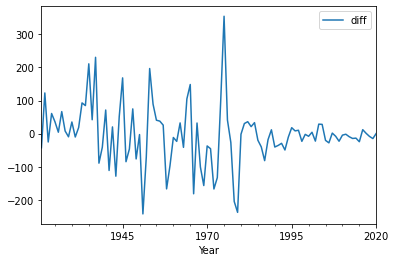

In [10]:
# Convert differenced series to a time-series data, first column is year with index, second column is the difference
df_diff = pd.DataFrame(diff)

# Rename Index to year
df_diff.index.name = 'Year'

# Add 1921 to the index
df_diff.index = df_diff.index + 1921

# Rename Column to difference
df_diff.columns = ['diff']

# Change index to datetime year
df_diff.index = pd.to_datetime(df_diff.index, format='%Y')
# Set index to period year
df_diff = df_diff.to_period('Y')

# Plot the differenced series
df_diff.plot()

# Rename dataframes
# df_old = df
# df = df_diff

In [25]:
# Create an LSTM model
from numpy import array
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import mean_absolute_error
from math import sqrt

# df = df_diff

# Split a univariate sequence into samples
def split_sequence(sequence, n_steps):
    x, y = list(), list()
    for i in range(len(sequence)):
        end_ix = i + n_steps
        if end_ix > len(sequence) - 1:
            break
        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
        x.append(seq_x)
        y.append(seq_y)
    return np.array(x), np.array(y)

# Define input sequence
raw_seq = df_calve.values
# Choose a number of time steps
n_steps = 3
# Split into samples
x, y = split_sequence(raw_seq, n_steps)
# Reshape from [samples, timesteps] into [samples, timesteps, features]
n_features = 1
x = x.reshape((x.shape[0], x.shape[1], n_features))
# Define LSTM model
model = Sequential()
model.add(LSTM(50, activation='relu', input_shape=(n_steps, n_features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')
# Fit model
model.fit(x, y, epochs=200, verbose=0)
# Make predictions
predictions = model.predict(x)
# demonstrate prediction
x_input = array([[raw_seq[-3], raw_seq[-2], raw_seq[-1]]])
x_input = x_input.reshape((1, n_steps, n_features))
yhat = model.predict(x_input, verbose=0)
print(yhat)

# Calculate RMSE
rmse = sqrt(mean_squared_error(y, predictions))
print('Test RMSE: %.3f' % rmse)

# Calculate MAPE
mape = mean_absolute_percentage_error(y, predictions)
print('Test MAPE: %.3f' % mape)

# Calculate MAE
mae = mean_absolute_error(y, predictions)
print('Test MAE: %.3f' % mae)

4/4 [==============================] - 0s 2ms/step
[[219.28442]]
Test RMSE: 101.843
Test MAPE: 0.082
Test MAE: 68.165


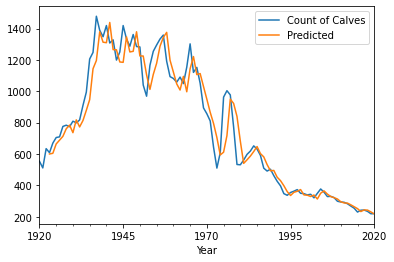

In [26]:
# Compare actual and predicted values in pvt_yr dataframe
from matplotlib import pyplot as plt

pred = [None, None, None]
pred.extend(predictions.flatten())

prt_yr = df_calve.copy()
prt_yr['Predicted'] = pred

# Plot actual and predicted values
prt_yr.plot()
plt.show()